In [ ]:
!nvidia-smi


Wed Jan 14 17:04:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.07             Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0  On |                  N/A |
| 53%   38C    P2             93W /  340W |    9650MiB /  10240MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip -q install text2vec==1.3.7 scikit-learn openpyxl pandas numpy tqdm

In [ ]:
!pip -q install text2vec==1.3.7 scikit-learn openpyxl pandas numpy tqdm xgboost sentence-transformers


In [ ]:
!pip install -U transformers datasets accelerate


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier




In [ ]:
PIPELINE = "simcse_svm"
# 可选：
# "tfidf_lr"     : TF-IDF + LogisticRegression
# "simcse_svm"   : SimCSE + LinearSVC
# "simcse_xgb"   : SimCSE + XGBoost（GPU）
# "bert_roberta" : RoBERTa
TEXT_COL  = "text"
LABEL_COL = "final_label"

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            11Gi       5.7Gi       4.3Gi       249Mi       1.6Gi       5.5Gi
Swap:          4.0Gi       2.9Gi       1.1Gi


In [ ]:
print("Files in /content:", os.listdir("/content"))

Files in /content: ['bert_output', 'checkpoints', 'modle对比.xlsx', 'simhei.ttf', 'test_human_400.xlsx', 'test_llm_1200.xlsx', 'train_llm_4800.xlsx']


In [ ]:
TRAIN_FILE = "/content/train_llm_4800.xlsx"
TEST_FILES = {
    "test_llm_1200":   "/content/test_llm_1200.xlsx",
    "test_human_400":  "/content/test_human_400.xlsx",
}

assert os.path.exists(TRAIN_FILE), f"找不到: {TRAIN_FILE}"
for name, path in TEST_FILES.items():
    assert os.path.exists(path), f"找不到: {path}"

In [ ]:
# 读取与清洗
def clean_df(df):
    df = df.copy()
    df[TEXT_COL]  = df[TEXT_COL].astype(str).str.strip()
    df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()
    df = df.dropna(subset=[TEXT_COL, LABEL_COL])
    df = df[(df[TEXT_COL] != "") & (df[LABEL_COL] != "")]
    return df

df_train = clean_df(pd.read_excel(TRAIN_FILE))
test_dfs = {name: clean_df(pd.read_excel(path)) for name, path in TEST_FILES.items()}


In [ ]:
#标签编码
le = LabelEncoder()
le.fit(df_train[LABEL_COL].values)

X_train_text = df_train[TEXT_COL].tolist()
y_train      = le.transform(df_train[LABEL_COL].values)

print("Train:", len(X_train_text))
print("Classes:", list(le.classes_))
for name, df in test_dfs.items():
    print(name, ":", len(df))

Train: 4790
Classes: ['neg', 'neu', 'pos']
test_llm_1200 : 1203
test_human_400 : 396


In [ ]:
# 保存模型的评估结果
RESULTS_STORE = {}
LAST_RUN_TITLE = None

In [ ]:
#统一评估函数
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_on_tests(predict_fn, title):
    global RESULTS_STORE, LAST_RUN_TITLE

    results = {}
    for name, df in test_dfs.items():
        X_test_text = df[TEXT_COL].tolist()
        y_test = le.transform(df[LABEL_COL].values)
        y_pred = predict_fn(X_test_text)

        print("\n" + "="*70)
        print(f"[{title}]  EVAL ON: {name}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        results[name] = {"y_test": y_test, "y_pred": y_pred}


    RESULTS_STORE[title] = results
    LAST_RUN_TITLE = title

    return results



In [ ]:
# TF-IDF + LogisticRegression

def run_tfidf_lr():
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression

    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
    X_train_tfidf = tfidf.fit_transform(X_train_text)

    clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=12)
    clf.fit(X_train_tfidf, y_train)

    def predict_fn(test_texts):
        X_test_tfidf = tfidf.transform(test_texts)
        return clf.predict(X_test_tfidf)

    results = evaluate_on_tests(predict_fn, "TFIDF+LR")
    return results


if PIPELINE == "tfidf_lr":
    run_tfidf_lr()
else:
    print("⏭️ skip: TFIDF+LR (PIPELINE =", PIPELINE, ")")

⏭️ skip: TFIDF+LR (PIPELINE = simcse_svm )


In [ ]:
# SimCSE (fine-tuned) + SVM / XGB


def run_simcse_svm():
    import torch
    from sentence_transformers import SentenceTransformer
    from sklearn.svm import LinearSVC

    ft_model = SentenceTransformer(
        "/data/simcse_ft_3cls",
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    X_train_ft = ft_model.encode(X_train_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

    clf = LinearSVC(C=1.0, class_weight="balanced", random_state=42)
    clf.fit(X_train_ft, y_train)

    def predict_fn(test_texts):
        X_test_ft = ft_model.encode(test_texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
        return clf.predict(X_test_ft)

    results = evaluate_on_tests(predict_fn, "SimCSE+SVM")
    return results



def run_simcse_xgb():
    import torch
    from sentence_transformers import SentenceTransformer
    from xgboost import XGBClassifier

    ft_model = SentenceTransformer(
        "/data/simcse_ft_3cls",
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    X_train_ft = ft_model.encode(X_train_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

    clf = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        device="cuda",
        objective="multi:softmax",
        num_class=len(le.classes_)
    )
    clf.fit(X_train_ft, y_train)

    def predict_fn(test_texts):
        X_test_ft = ft_model.encode(test_texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
        return clf.predict(X_test_ft)

    results = evaluate_on_tests(predict_fn, "SimCSE+XGB")
    return results




if PIPELINE == "simcse_svm":
    run_simcse_svm()
elif PIPELINE == "simcse_xgb":
    run_simcse_xgb()
else:
    print("⏭️ skip: SimCSE(ft) (PIPELINE =", PIPELINE, ")")

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_llm_1200
Accuracy: 0.8403990024937655
              precision    recall  f1-score   support

         neg     0.8957    0.8832    0.8894       642
         neu     0.7226    0.7529    0.7374       263
         pos     0.8311    0.8255    0.8283       298

    accuracy                         0.8404      1203
   macro avg     0.8165    0.8205    0.8184      1203
weighted avg     0.8419    0.8404    0.8410      1203

Confusion matrix:
 [[567  49  26]
 [ 41 198  24]
 [ 25  27 246]]


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_human_400
Accuracy: 0.797979797979798
              precision    recall  f1-score   support

         neg     0.8325    0.8579    0.8450       197
         neu     0.7412    0.6000    0.6632       105
         pos     0.7778    0.8936    0.8317        94

    accuracy                         0.7980       396
   macro avg     0.7838    0.7838    0.7799       396
weighted avg     0.7953    0.7980    0.7936       396

Confusion matrix:
 [[169  17  11]
 [ 29  63  13]
 [  5   5  84]]


In [ ]:
# RoBERTa

if PIPELINE != "bert_roberta":
    print("⏭️ skip: RoBERTa fine-tune (PIPELINE =", PIPELINE, ")")
else:
    import os
    os.environ["WANDB_DISABLED"] = "true"
    os.environ["WANDB_MODE"] = "disabled"

    import numpy as np
    import torch
    from datasets import Dataset
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        DataCollatorWithPadding
    )
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)


    HF_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"

    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)

    def build_dataset(texts, labels):
        return Dataset.from_dict({"text": list(texts), "label": list(labels)})


    ds_train = build_dataset(X_train_text, y_train)


    X_test_text = test_dfs["test_llm_1200"][TEXT_COL].tolist()
    y_test      = le.transform(test_dfs["test_llm_1200"][LABEL_COL].values)

    X_gold_text = test_dfs["test_human_400"][TEXT_COL].tolist()
    y_gold      = le.transform(test_dfs["test_human_400"][LABEL_COL].values)

    ds_test = build_dataset(X_test_text, y_test)
    ds_gold = build_dataset(X_gold_text, y_gold)

    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding=False,
            max_length=128
        )

    ds_train = ds_train.map(tokenize_fn, batched=True)
    ds_test  = ds_test.map(tokenize_fn, batched=True)
    ds_gold  = ds_gold.map(tokenize_fn, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        HF_MODEL_NAME,
        num_labels=len(le.classes_)
    ).to(device)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {"accuracy": accuracy_score(labels, preds)}

    common_args = dict(
        output_dir="./bert_output",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )


    try:
        training_args = TrainingArguments(**common_args, evaluation_strategy="epoch")
    except TypeError:
        training_args = TrainingArguments(**common_args, eval_strategy="epoch")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()


    def eval_one(y_true, y_pred, name):
        print("\n" + "="*70)
        print(f"[RoBERTa fine-tuned]  EVAL ON: {name}")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

    preds_test = trainer.predict(ds_test)
    y_pred_test = np.argmax(preds_test.predictions, axis=1)
    eval_one(y_test, y_pred_test, "test_llm_1200")

    preds_gold = trainer.predict(ds_gold)
    y_pred_gold = np.argmax(preds_gold.predictions, axis=1)
    eval_one(y_gold, y_pred_gold, "test_human_400")

    results = evaluate_on_tests(predict_fn, "bert_roberta")


⏭️ skip: RoBERTa fine-tune (PIPELINE = simcse_svm )


In [ ]:
def run_selected(p):
    global results

    if p == "tfidf_lr":
        results = run_tfidf_lr()
    elif p == "simcse_svm":
        results = run_simcse_svm()
    elif p == "simcse_xgb":
        results = run_simcse_xgb()
    elif p == "bert_roberta":
        results = run_bert_roberta()
    else:
        raise ValueError(f"Unknown PIPELINE: {p}")

run_selected(PIPELINE)


print("results keys:", results.keys())


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_llm_1200
Accuracy: 0.8403990024937655
              precision    recall  f1-score   support

         neg     0.8957    0.8832    0.8894       642
         neu     0.7226    0.7529    0.7374       263
         pos     0.8311    0.8255    0.8283       298

    accuracy                         0.8404      1203
   macro avg     0.8165    0.8205    0.8184      1203
weighted avg     0.8419    0.8404    0.8410      1203

Confusion matrix:
 [[567  49  26]
 [ 41 198  24]
 [ 25  27 246]]


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_human_400
Accuracy: 0.797979797979798
              precision    recall  f1-score   support

         neg     0.8325    0.8579    0.8450       197
         neu     0.7412    0.6000    0.6632       105
         pos     0.7778    0.8936    0.8317        94

    accuracy                         0.7980       396
   macro avg     0.7838    0.7838    0.7799       396
weighted avg     0.7953    0.7980    0.7936       396

Confusion matrix:
 [[169  17  11]
 [ 29  63  13]
 [  5   5  84]]
results keys: dict_keys(['test_llm_1200', 'test_human_400'])


In [ ]:
curr = RESULTS_STORE[LAST_RUN_TITLE]
y_test = curr["test_human_400"]["y_test"]
y_pred = curr["test_human_400"]["y_pred"]
print("Using model:", LAST_RUN_TITLE)



Using model: SimCSE+SVM


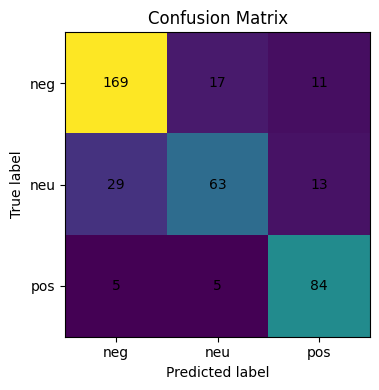

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ["neg", "neu", "pos"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


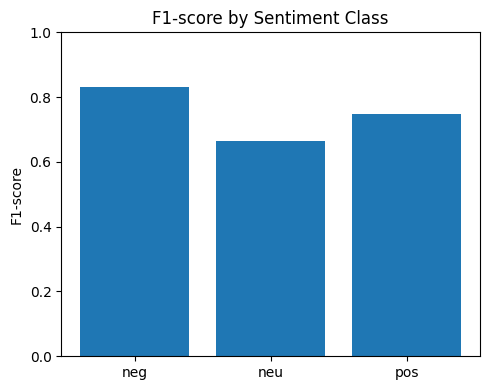

In [ ]:
labels = ["neg", "neu", "pos"]
f1_scores = [0.8324, 0.6656, 0.7470]

plt.figure(figsize=(5, 4))
plt.bar(labels, f1_scores)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("F1-score by Sentiment Class")

plt.tight_layout()
plt.show()


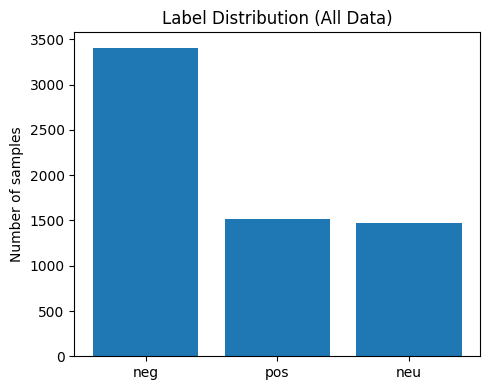

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_all = pd.concat(
    [df_train, test_dfs["test_llm_1200"], test_dfs["test_human_400"]],
    ignore_index=True
)

counts = df_all["final_label"].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Number of samples")
plt.title("Label Distribution (All Data)")
plt.tight_layout()
plt.show()


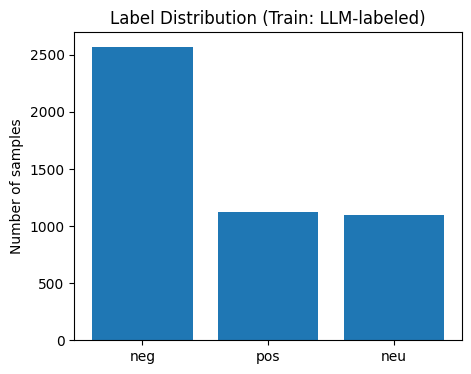

In [ ]:
counts = df_train["final_label"].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Number of samples")
plt.title("Label Distribution (Train: LLM-labeled)")
plt.show()


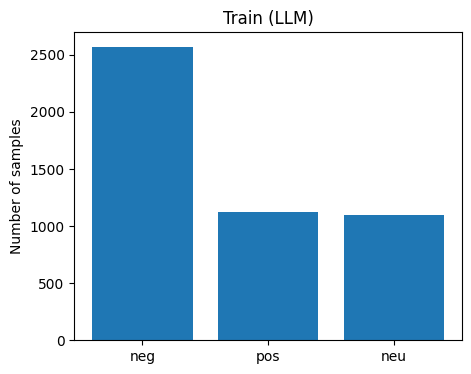

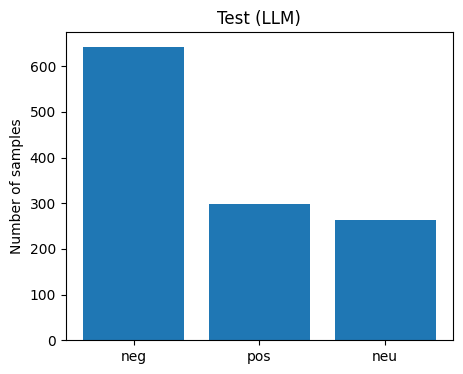

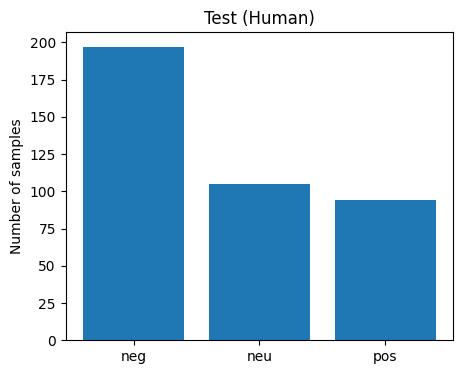

In [ ]:
def plot_dist(df, title):
    counts = df["final_label"].value_counts()
    plt.figure(figsize=(5, 4))
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.ylabel("Number of samples")
    plt.show()

plot_dist(df_train, "Train (LLM)")
plot_dist(test_dfs["test_llm_1200"], "Test (LLM)")
plot_dist(test_dfs["test_human_400"], "Test (Human)")


In [ ]:
import pandas as pd

def evaluate_on_tests(predict_fn, title: str):
    results = {}
    for name, df in test_dfs.items():
        X_test_text = df[TEXT_COL].tolist()
        y_test = le.transform(df[LABEL_COL].values)
        y_pred = predict_fn(X_test_text)

        print("\n" + "="*70)
        print(f"[{title}]  EVAL ON: {name}")
        # ... 你原来的print不变 ...

        results[name] = (y_test, y_pred)
    return results


In [ ]:
print("LAST_RUN_TITLE =", LAST_RUN_TITLE)
print("RESULTS_STORE keys =", list(RESULTS_STORE.keys()))


LAST_RUN_TITLE = SimCSE+SVM
RESULTS_STORE keys = ['SimCSE+SVM']


In [ ]:
run_selected(PIPELINE)
curr = RESULTS_STORE[LAST_RUN_TITLE]
y_test = curr["test_human_400"]["y_test"]
y_pred = curr["test_human_400"]["y_pred"]


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_llm_1200


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


[SimCSE+SVM]  EVAL ON: test_human_400


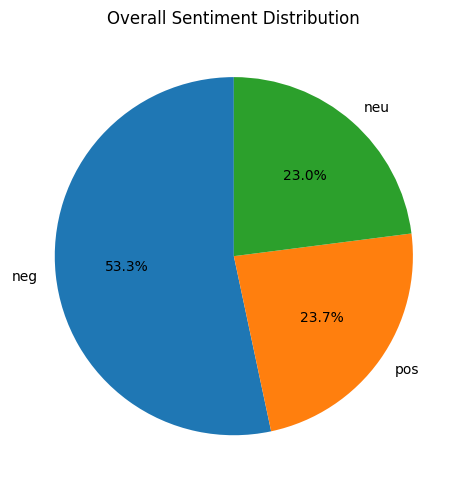

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df_all = pd.concat([df_train, *test_dfs.values()], ignore_index=True)


counts = df_all["final_label"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct="%.1f%%",
    startangle=90
)
plt.title("Overall Sentiment Distribution")
plt.tight_layout()
plt.show()

In [ ]:
!pip -q install jieba wordcloud


In [ ]:
!ls /usr/share/fonts/truetype/

humor-sans  liberation


In [ ]:
!ls /usr/share/fonts/truetype/*/

/usr/share/fonts/truetype/humor-sans/:
Humor-Sans.ttf

/usr/share/fonts/truetype/liberation/:
LiberationMono-BoldItalic.ttf	     LiberationSansNarrow-Bold.ttf
LiberationMono-Bold.ttf		     LiberationSansNarrow-Italic.ttf
LiberationMono-Italic.ttf	     LiberationSansNarrow-Regular.ttf
LiberationMono-Regular.ttf	     LiberationSans-Regular.ttf
LiberationSans-BoldItalic.ttf	     LiberationSerif-BoldItalic.ttf
LiberationSans-Bold.ttf		     LiberationSerif-Bold.ttf
LiberationSans-Italic.ttf	     LiberationSerif-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Regular.ttf


In [ ]:
import re
import jieba

# 停用词表
stopwords = set("""
的 了 和 是 就 都 也 还 很 在 有 没有 不 是的 不是 但是 因为 所以 如果 这个 那个 这样 那样
一个 一种 这些 那些 我 你 他 她 它 我们 你们 他们 自己 大家 人 时候 现在 觉得 真的
会 能 可以 需要 应该 可能 还是 还有 其实 发生 看到 听说
""".split())


def clean_and_cut(text):
    text = str(text)

    text = re.sub(r"[^\u4e00-\u9fff]+", " ", text)
    words = jieba.lcut(text)

    words = [w for w in words if (len(w) >= 2 and w not in stopwords)]
    return words

pos_texts = df_all[df_all["final_label"] == "pos"]["text"].astype(str)

pos_words = []
for t in pos_texts:
    pos_words.extend(clean_and_cut(t))

pos_text = " ".join(pos_words)

print("pos words (after filtering):", len(pos_words))
print("example:", pos_words[:30])

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.581 seconds.
DEBUG:jieba:Loading model cost 0.581 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


pos words (after filtering): 10957
example: ['我要', '幸福', '一生', '你好', '魅力', '思想', '思考', '女性', '魅力', '太对', '筛选', '机制', '超高', '遨游', '苍穹', '一起', '遨游', '世界', '遇到', '事情', '一起', '商量', '解决', '双方', '真爱', '每天', '一起', '一起', '幸福', '好处']


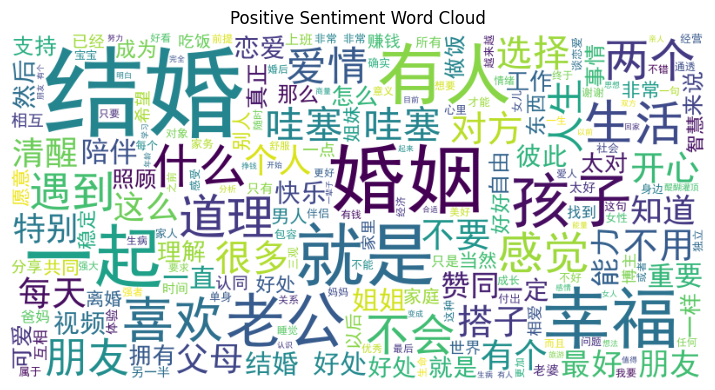

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

FONT_PATH = "/content/simhei.ttf"
assert os.path.exists(FONT_PATH), "找不到字体文件：/data/simhei.ttf"


wc_pos = WordCloud(
    font_path=FONT_PATH,
    width=800,
    height=400,
    background_color="white"
)

plt.figure(figsize=(8, 4))
plt.imshow(wc_pos.generate(pos_text))
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.tight_layout()
plt.show()

In [ ]:
import jieba


neg_texts = df_all[df_all["final_label"] == "neg"]["text"].astype(str)

neg_words = []
for t in neg_texts:
    neg_words.extend(jieba.lcut(t))

neg_text = " ".join(neg_words)

print("负面文本长度：", len(neg_text))


负面文本长度： 180424


In [ ]:
stopwords_neg = set("""
的 了 和 是 就 都 也 还 很 在 有 没 不 不是
可以 不能 能 会 要 不要
一个 一种 这些 那些 这样 那样 这种
我 你 他 她 它 我们 你们 他们
现在 以后 之前 已经 觉得 感觉 认为
如果 因为 所以 但是 而且 然后
什么 怎么 为什么 哪个
这样 那个 这个
""".split())


In [ ]:
stopwords_neg.update("""
结婚 婚姻 婚后 离婚
就是 这样 那么 还是 可能 真的
不要 不想 不会 没有 不是
一个 两个 这种 那种
""".split())


In [ ]:
import re
import jieba

def clean_and_cut_neg(text):
    text = str(text)

    text = re.sub(r"[^\u4e00-\u9fff]+", " ", text)
    words = jieba.lcut(text)

    words = [
        w for w in words
        if len(w) >= 2 and w not in stopwords_neg
    ]
    return words

neg_texts = df_all[df_all["final_label"] == "neg"]["text"].astype(str)

neg_words = []
for t in neg_texts:
    neg_words.extend(clean_and_cut_neg(t))

neg_text = " ".join(neg_words)

print("neg words after filtering:", len(neg_words))
print("example:", neg_words[:30])


neg words after filtering: 25815
example: ['缺失', '抽身', '离开', '勇气', '我长', '这么', '遇到', '糟糕', '普通', '朋友', '共度', '一生', '可怕', '找个', '正常人', '太难', '这么', '人人', '有些', '跳脚', '越来越', '拐卖', '年轻', '女孩', '偏远', '山区', '延续', '后代', '甚至', '出现']


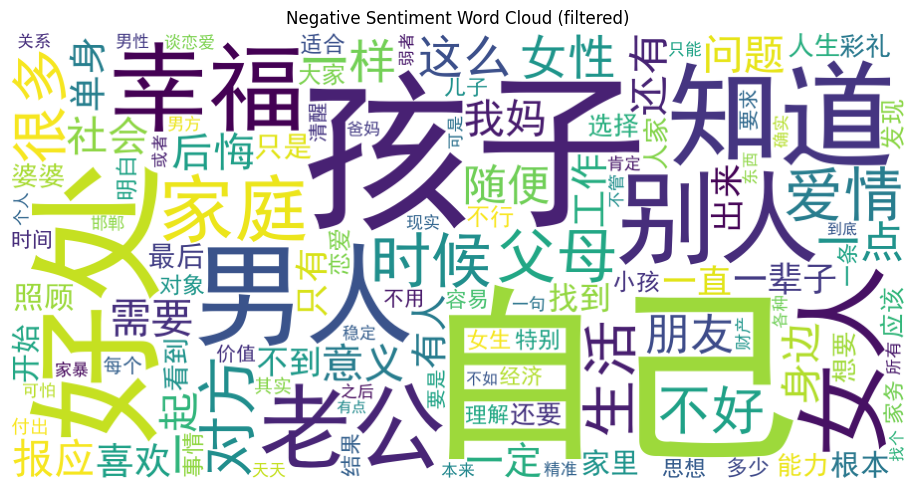

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

FONT_PATH = "/content/simhei.ttf"
assert os.path.exists(FONT_PATH), "找不到字体文件：/data/simhei.ttf"


wc_neg = WordCloud(
    font_path=FONT_PATH,
    width=900,
    height=450,
    background_color="white",
    max_words=120,
    collocations=False,
    min_word_length=2
)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg.generate(neg_text))
plt.axis("off")
plt.title("Negative Sentiment Word Cloud (filtered)")
plt.tight_layout()
plt.show()
